# GeoAI with Foundational Models: From Satellite Pixels to Environmental Insights

**MSc Environmental Data Science & Machine Learning – Week 3 Practical**

**Learning Objectives**
- Understand how Sentinel-2 imagery is represented as multi-dimensional tensors
- Extract geographic coordinates from raster data (spatial thinking)
- Compute classic spectral indices (e.g., NDVI) and interpret them environmentally
- Patch large rasters for scalable processing
- Generate embeddings from image patches using a stand-in encoder (conceptually replaceable with real foundation models like SAM or DINOv2)
- Visualise and cluster embeddings, then map results back to geography
- Reflect on how these representations support environmental decision-making

**Why this matters**
Modern environmental data science rarely involves training convolutional networks from scratch. Instead, we **consume pre-trained foundation models** to obtain rich representations (embeddings) and design workflows around them. This practical shows the end-to-end pipeline you will use for tasks such as land-cover monitoring, deforestation detection, or vineyard climate-risk assessment.

### Imports and Setup

In [30]:
# Standard scientific stack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Scikit-learn tools for embeddings & clustering
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Optional real-world visualisation (uncomment when ready)
# import leafmap
# import rasterio
# from samgeo import SamGeo

# For reproducibility
np.random.seed(42)

print("All imports successful!")

All imports successful!


## 1. Sentinel-2 Data as a 3D Tensor

Sentinel-2 provides multispectral imagery at 10 m resolution for several useful bands.  
A single tile is stored as a 3D array: **(Channels, Height, Width)**.

This structure is exactly what deep vision models expect as input.

### Create Synthetic Sentinel - 2 Tile

In [31]:
# Define the four most common 10 m bands for land-cover tasks
bands = ["B2 (Blue)", "B3 (Green)", "B4 (Red)", "B8 (NIR)"]
C = len(bands)          # Channels
H, W = 256, 256         # Height & Width in pixels (small tile for demo)
pixel_size_m = 10       # Spatial resolution

# Synthetic reflectance values [0–1] (real data would be loaded from GeoTIFF/STAC)
X = np.random.uniform(0.0, 1.0, size=(C, H, W))

print(f"Tensor shape (C, H, W): {X.shape}")
print(f"Each pixel covers {pixel_size_m} m × {pixel_size_m} m")
print(f"Tile footprint ≈ {(H*pixel_size_m)/1000:.1f} km × {(W*pixel_size_m)/1000:.1f} km")

Tensor shape (C, H, W): (4, 256, 256)
Each pixel covers 10 m × 10 m
Tile footprint ≈ 2.6 km × 2.6 km


Even synthetic data lets us explore the exact same data structures used with real EO products. The shape (4, 256, 256) is typical input for patch-based foundation models

### Visualize RGB Composite

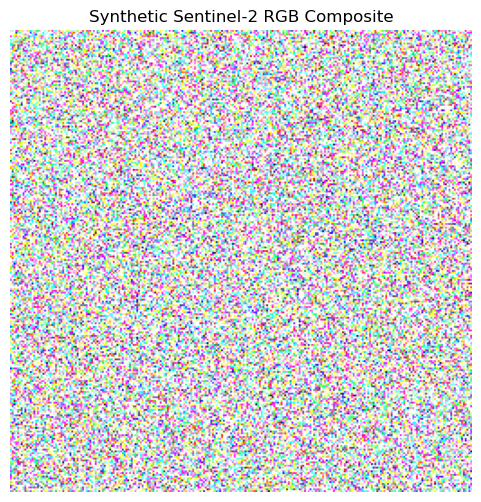

In [32]:
# Standard false-colour RGB using B4, B3, B2
rgb = np.stack([X[2], X[1], X[0]], axis=-1)  # (H, W, 3)

plt.figure(figsize=(6, 6))
plt.imshow(np.clip(rgb * 2.5, 0, 1))  # contrast stretch for display
plt.title("Synthetic Sentinel-2 RGB Composite")
plt.axis("off")
plt.show()

Human eyes see three channels. Adding NIR (B8) later gives vegetation a strong signature — the basis for indices like NDVI.

## 2. From Pixel Indices to Real-World Coordinates

Satellite images are not just arrays of numbers — they are **maps**.  
Every pixel corresponds to a specific location on Earth.

Real GeoTIFF files contain an **affine transform** that defines:
- The coordinate (x0, y0) of the top-left pixel corner
- The pixel size in metres
- The direction of rows/columns

We simulate this here so that later we can:
- Know the **geographic centre** of each image patch
- Plot clustering results **back on the map**
- Prepare for overlaying with climate data, field measurements, or protected-area boundaries

This step is essential for any environmental application: without coordinates, we cannot answer "where?" questions.

In [35]:
x0, y0 = 500_000, 5_000_000  # example UTM origin

cols = np.arange(W)
rows = np.arange(H)

Xcoord = x0 + cols[None, :] * pixel_size_m
Ycoord = y0 - rows[:, None] * pixel_size_m

print("Xcoord shape:", Xcoord.shape)
print("Ycoord shape:", Ycoord.shape)


Xcoord shape: (1, 256)
Ycoord shape: (256, 1)


This step bridges pure image processing with geospatial analysis — essential for overlaying climate layers, field measurements, or policy boundaries.

## 3. Simulating Realistic Land-Cover Spectra

We create four simple land-cover classes with plausible Sentinel-2 reflectance values and add sensor noise.

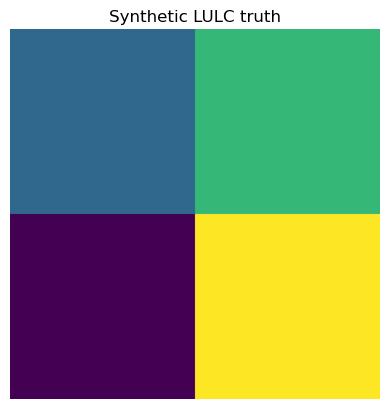

In [36]:
lulc = np.zeros((H, W), dtype=int)

lulc[:128, :128] = 1   # vegetation
lulc[:128, 128:] = 2   # urban
lulc[128:, :128] = 0   # water
lulc[128:, 128:] = 3   # bare soil

proto = {
    0: np.array([0.05, 0.05, 0.03, 0.02]),  # water
    1: np.array([0.05, 0.08, 0.03, 0.45]),  # vegetation
    2: np.array([0.18, 0.20, 0.22, 0.25]),  # urban
    3: np.array([0.12, 0.14, 0.18, 0.22]),  # bare soil
}

X = np.zeros((C, H, W))
for cls, vec in proto.items():
    for c in range(C):
        X[c][lulc == cls] = vec[c]

X += np.random.normal(0, 0.01, X.shape)
X = np.clip(X, 0, 1)

plt.imshow(lulc)
plt.title("Synthetic LULC truth")
plt.axis("off")
plt.show()


### NDVI vs learned representations

NDVI is a classic index — powerful but limited.

Foundation models:

do not compress information into one number

learn multi-dimensional representations


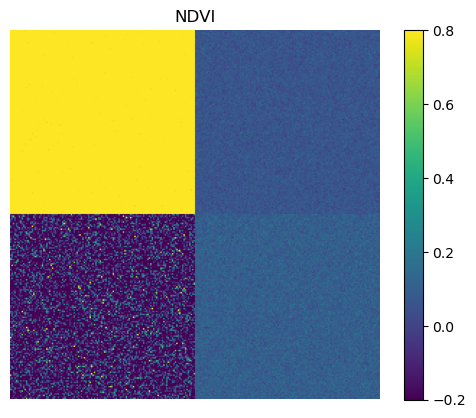

In [37]:
red = X[2]
nir = X[3]

ndvi = (nir - red) / (nir + red + 1e-6)

plt.imshow(ndvi, vmin=-0.2, vmax=0.8)
plt.title("NDVI")
plt.axis("off")
plt.colorbar()
plt.show()


NDVI separates vegetation well

But struggles with urban vs bare soil

Embeddings overcome this limitation

📌 Real workflow equivalent:
Index-based baselines vs deep representations

### Path Extraction

In [38]:
P = 32
stride = 32

patches = []
centers_xy = []
patch_truth = []

for r in range(0, H-P+1, stride):
    for c in range(0, W-P+1, stride):
        patches.append(X[:, r:r+P, c:c+P])
        centers_xy.append([Xcoord[0, c+P//2], Ycoord[r+P//2, 0]])
        patch_truth.append(np.bincount(lulc[r:r+P, c:c+P].ravel()).argmax())

patches = np.stack(patches)
centers_xy = np.array(centers_xy)
patch_truth = np.array(patch_truth)

print("Patch tensor:", patches.shape)


Patch tensor: (64, 4, 32, 32)


Interpretation

(B, C, P, P) is the standard EO model input

Patch size defines spatial scale

📌 Real workflow equivalent:
CNN / ViT patching in EO foundation models

### Embeddings (output of a foundation model)

In [39]:
from sklearn.random_projection import GaussianRandomProjection

B = patches.shape[0]
patch_vectors = patches.reshape(B, -1)

encoder = GaussianRandomProjection(n_components=64, random_state=0)
E = encoder.fit_transform(patch_vectors)

print("Embeddings shape:", E.shape)


Embeddings shape: (64, 64)


### Undesrtanding embedding space (PCA)

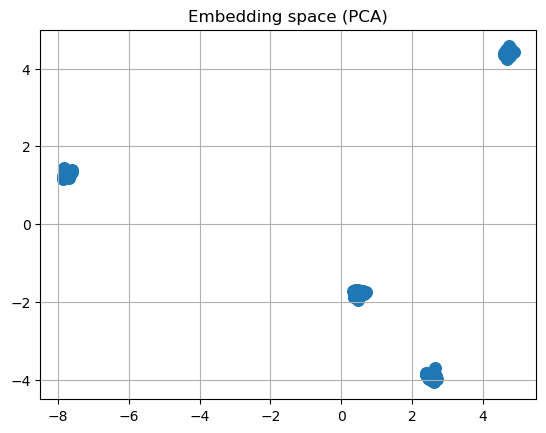

In [40]:
from sklearn.decomposition import PCA

E2 = PCA(n_components=2).fit_transform(E)

plt.scatter(E2[:,0], E2[:,1], s=70)
plt.title("Embedding space (PCA)")
plt.grid(True)
plt.show()


### Unsupervised land-use 

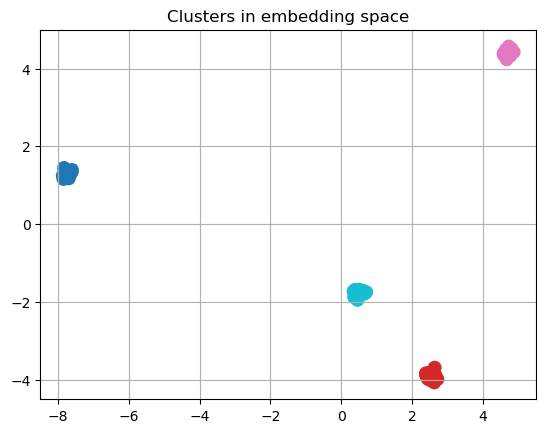

In [41]:
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=4, random_state=0).fit_predict(E)

plt.scatter(E2[:,0], E2[:,1], c=clusters, cmap="tab10", s=80)
plt.title("Clusters in embedding space")
plt.grid(True)
plt.show()


### Mapping back to geography

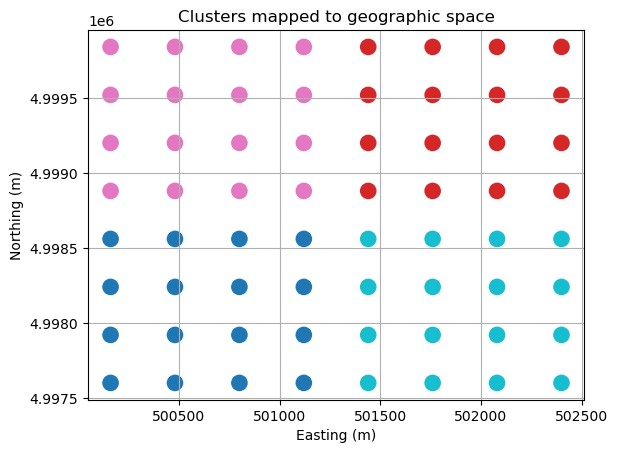

In [42]:
plt.scatter(centers_xy[:,0], centers_xy[:,1],
            c=clusters, cmap="tab10", s=120)
plt.title("Clusters mapped to geographic space")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True)
plt.show()
